# About

This notebook demonstrates several additional tools to optimize classification model provided by __Reproducible experiment platform (REP)__ package:

* __grid search for the best classifier hyperparameters__

* __different optimization algorithms__ 

* __different scoring models__ (optimization of arbirtary figure of merit)



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Loading data for Higgs Boson Challenge

In [2]:
import numpy, pandas
from rep.utils import train_test_split
from sklearn.metrics import roc_auc_score

data = pandas.read_csv('toy_datasets/Higgs.csv', sep='\t')
labels = data['Label'].values
labels = labels == 's'
sample_weight = data['Weight'].values

train_data, test_data, train_labels, test_labels, train_weight, test_weight = train_test_split(data, labels, sample_weight)

list(data.columns)

['EventId',
 'DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'DER_lep_eta_centrality',
 'PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi',
 'PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_jet_all_pt',
 'Weight',
 'Label']

## Variables used in training

In [3]:
features = list(set(data.columns) - set(['Weight', 'Label', 'EventId']))

# Metric definition

In Higgs challenge the aim is to maximize `AMS` metrics. <br />
To measure the quality one should choose not only classifier, but also an optimal threshold, 
where the maximal value of `AMS` is achieved.

Such metrics (which require a threshold) are called threshold-based.

__rep.utils__ contain class __OptimalMetric__, which computes the maximal value for threshold-based metric (and may be used as metric).

Use this class to generate metric and use it in grid search.

## Prepare quality metric

first we define AMS metric, and `utils.OptimalMetric` generates 

In [4]:
from rep.report import metrics

In [5]:
def AMS(s, b): 
    br = 10.0
    radicand = 2 *( (s+b+br) * numpy.log (1.0 + s/(b+br)) - s)
    return numpy.sqrt(radicand)

optimal_AMS = metrics.OptimalMetric(AMS, expected_s=692., expected_b=410999.)

### Compute threshold vs metric quality
random predictions for signal and background were used here

Optimal cut=0.0004, quality=1.0802


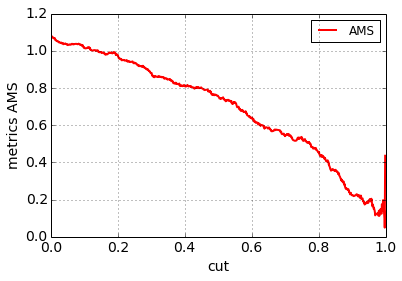

In [6]:
probs_rand = numpy.ndarray((1000, 2))
probs_rand[:, 1] = numpy.random.random(1000)
probs_rand[:, 0] = 1 - probs_rand[:, 1]
labels_rand = numpy.random.randint(0, high=2, size=1000)

optimal_AMS.plot_vs_cut(labels_rand, probs_rand)

### The best quality

In [7]:
optimal_AMS(labels_rand, probs_rand)

1.0801533437621837

# Hyperparameters optimization algorithms

__AbstractParameterGenerator__ is an abstract class to generate new points, where the scorer function will be computed. It is used in grid search to get new set of parameters to train classifier.

__Properties__:

* `best_params_` - return the best grid point

* `best_score_` - return the best quality

* `print_results(self, reorder=True)` - print all points with corresponding quality


The following algorithms inherit from __AbstractParameterGenerator__:

* `RandomParameterOptimizer` -  generates random point in parameters space
    
* `RegressionParameterOptimizer` - generate next point using regression algorithm, which was trained on previous results
    
* `SubgridParameterOptimizer` - uses subgrids if grid is huge + annealing-like technique (details see in __REP__)

# Grid search

__GridOptimalSearchCV__ implemets optimal search over specified parameter values for an estimator. Parameters to use it are:

* estimator - object of type that implements the "fit" and "predict" methods

* params_generator - generator of grid search algorithm (AbstractParameterGenerator)

* scorer -  which implement method __call__ with kwargs: "base_estimator", "params", "X", "y", "sample_weight"

* Important members are "fit", "fit_best_estimator"

In [8]:
from rep.metaml import GridOptimalSearchCV
from rep.metaml.gridsearch import RandomParameterOptimizer, FoldingScorer
from rep.estimators import SklearnClassifier
from sklearn.ensemble import AdaBoostClassifier
from collections import OrderedDict

## Grid search with folding scorer

__FoldingScorer__ provides folding cross-validation for train dataset:

* folds - `k`, number of folds (train on `k-1` fold, test on `1` fold)
* folds_check - number of times model will be tested
* score_function - function to calculate quality with interface "function(y_true, proba, sample_weight=None)"

__NOTE__: if fold_checks > 1, the quality is averaged over tests.


In [9]:
# define grid parameters
grid_param = OrderedDict()
grid_param['n_estimators'] = [10, 20, 30]
grid_param['learning_rate'] = [0.1, 0.05]

# use random hyperparameter optimization algorithm 
generator = RandomParameterOptimizer(grid_param)
# define folding scorer
scorer = FoldingScorer(optimal_AMS, folds=4, fold_checks=2)

grid_sk = GridOptimalSearchCV(SklearnClassifier(AdaBoostClassifier(), features=features), generator, scorer)
grid_sk.fit(data, labels)

### Print best parameters

In [10]:
grid_sk.generator.best_params_

OrderedDict([('n_estimators', 30), ('learning_rate', 0.1)])

### Print all qualities for used parameters

In [11]:
grid_sk.generator.print_results()

2.245:  n_estimators=30, learning_rate=0.1
2.106:  n_estimators=20, learning_rate=0.1
2.033:  n_estimators=30, learning_rate=0.05
1.777:  n_estimators=20, learning_rate=0.05
1.771:  n_estimators=10, learning_rate=0.1
1.767:  n_estimators=10, learning_rate=0.05


## Grid search with user-defined scorer

You can define your own scorer with specific logic by simple way. Scorer must have just the following:

* scorer(base_estimator, params, X, y, sample_weight)

### Prepare reweight function

In [12]:
def normed_weight(y, weight):
    weight[y == 1] *= sum(weight[y == 0]) / sum(weight[y == 1])
    return weight

### Define scorer, which will be train model on all dataset and test it on the pre-defined dataset

In [13]:
from sklearn import clone
def generate_scorer(test, labels, test_weight=None):
    """ Generate scorer which calculate metric on fixed test dataset """
    def custom(base_estimator, params, X, y, sample_weight=None):
        cl = clone(base_estimator)
        cl.set_params(**params)
        cl.fit(X, y)
        res = optimal_AMS(labels, cl.predict_proba(test), sample_weight=test_weight)
        return res
    return custom

In [14]:
# define grid parameters
grid_param = OrderedDict()
grid_param['n_estimators'] = [10, 20, 30]
grid_param['learning_rate'] = [0.1, 0.05]
grid_param['features'] = [features[:5], features[:10]]

# define random hyperparameter optimization algorithm 
generator = RandomParameterOptimizer(grid_param)
# define specific scorer
scorer = generate_scorer(test_data, test_labels, test_weight)

grid = GridOptimalSearchCV(SklearnClassifier(clf=AdaBoostClassifier(), features=features), generator, scorer)
grid.fit(train_data, train_labels, train_weight)

In [15]:
len(train_data), len(test_data)

(187500, 62500)

### Print all tried combinations of parameters and quality

In [16]:
grid.generator.print_results()

1.587:  n_estimators=30, learning_rate=0.1, features=['DER_pt_tot', 'PRI_jet_leading_phi', 'DER_mass_MMC', 'DER_met_phi_centrality', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_lep_eta', 'PRI_jet_subleading_phi', 'DER_sum_pt', 'PRI_tau_phi']
1.583:  n_estimators=20, learning_rate=0.1, features=['DER_pt_tot', 'PRI_jet_leading_phi', 'DER_mass_MMC', 'DER_met_phi_centrality', 'DER_prodeta_jet_jet']
1.583:  n_estimators=20, learning_rate=0.1, features=['DER_pt_tot', 'PRI_jet_leading_phi', 'DER_mass_MMC', 'DER_met_phi_centrality', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_lep_eta', 'PRI_jet_subleading_phi', 'DER_sum_pt', 'PRI_tau_phi']
1.575:  n_estimators=30, learning_rate=0.05, features=['DER_pt_tot', 'PRI_jet_leading_phi', 'DER_mass_MMC', 'DER_met_phi_centrality', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_lep_eta', 'PRI_jet_subleading_phi', 'DER_sum_pt', 'PRI_tau_phi']
1.575:  n_estimators=30, learning_rate=0.05, features=['DER_pt_tot', 'PRI_jet_leading_p

# Results comparison 

In [17]:
from rep.report import ClassificationReport
from rep.data.storage import LabeledDataStorage

lds = LabeledDataStorage(test_data, test_labels, test_weight)
classifiers = {'grid_fold': grid_sk.fit_best_estimator(train_data[features], train_labels, train_weight),
               'grid_test_dataset': grid.fit_best_estimator(train_data[features], train_labels, train_weight) }

report = ClassificationReport(classifiers, lds)

## ROCs

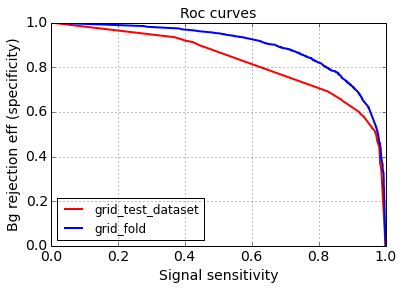

In [18]:
report.roc().plot()

## Metric

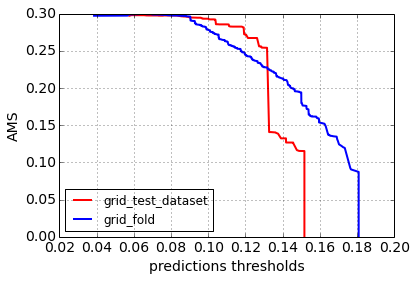

In [19]:
report.metrics_vs_cut(AMS, metric_label='AMS').plot()